In [380]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from plotnine import *

pd.set_option('display.max_row',None)

In [425]:
# read and drop non-important columns
data = pd.read_csv('paris.csv')
data.set_index('id',inplace=True)

## Data Cleaning of the Explained Variable: Price

In [426]:
# data cleaning: price, transfer from str to float
data.dropna(subset=["price"],inplace=True)
data["price"] = data["price"].str.replace(",", "")
data["price"] = data["price"].str.replace("$", "").astype("float")

# Have an Idea of the price datapoints
data.price.describe()

count    67108.000000
mean       221.161739
std        662.165493
min          8.000000
25%         86.000000
50%        129.000000
75%        205.000000
max      84420.000000
Name: price, dtype: float64

In [427]:
# Remove extreme values (3 sigma principle)
priceH = data.price.mean()+3*data.price.std()
priceL = data.price.mean()-3*data.price.std()

outliersH = data.loc[(data.price > priceH)]
outliersL = data.loc[(data.price < priceL)]

print('The outliers above 3 std of the mean have mean and std:')
OutliersH_stats = outliersH['price'].agg(['mean','std'])
display(OutliersH_stats)

print('The outliers below 3 std of the mean have mean and std:')
OutliersL_stats = outliersL['price'].agg(['mean','std'])
display(OutliersL_stats)

data = data.loc[(data.price < priceH) & (data.price > priceL) ]

The outliers above 3 std of the mean have mean and std:


mean    5269.735149
std     6290.611988
Name: price, dtype: float64

The outliers below 3 std of the mean have mean and std:


mean   NaN
std    NaN
Name: price, dtype: float64

In [428]:
# Have an Idea of the price datapoints
data.price.describe()

count    66704.000000
mean       190.584508
std        216.168587
min          8.000000
25%         86.000000
50%        128.000000
75%        200.000000
max       2201.000000
Name: price, dtype: float64

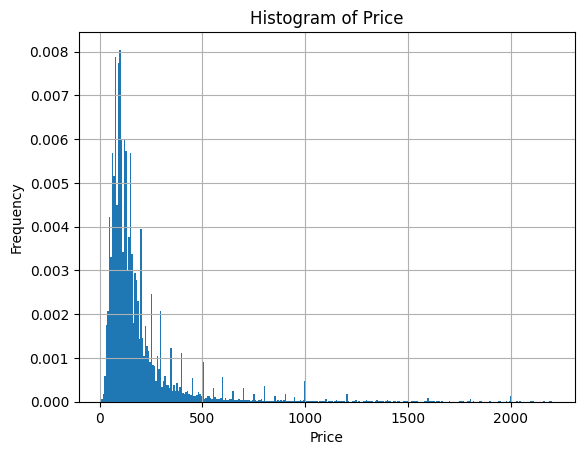

In [429]:
# plot histogram
plt.hist(data['price'], bins=300, density= True)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.title('Histogram of Price')
plt.show()

# We can see that we still have some outliers but it is important to keep some those that are realistic (in the +/- 3 std range) 
# because they are representative of the real estate market

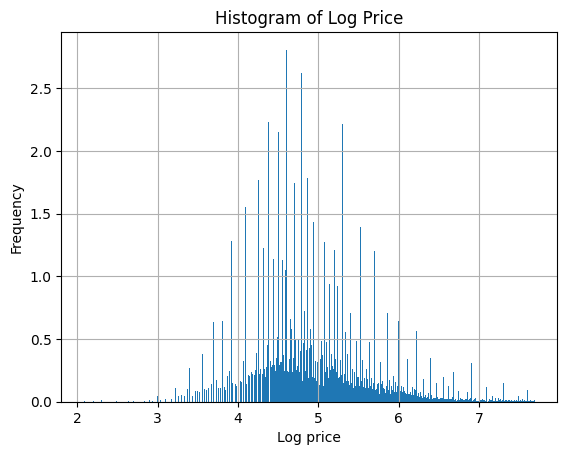

In [430]:
# calculate log price
data["ln_price"] = np.log(data.price)

# plot histogram
plt.hist(data['ln_price'], bins=500, density=True)
plt.xlabel('Log price')
plt.ylabel('Frequency')
plt.grid(True)
plt.title('Histogram of Log Price')
plt.show()

# Applying the log price allows us to have a distribution that is a bit more normal with thinner tails (more homoskedastic)

## Feature Selection

In [431]:
# See all of the features
original_data_columns_name = data.columns.tolist()
print(original_data_columns_name)
print(f'We have in total {len(original_data_columns_name)} columns')

['listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_36

In [432]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
scrape_id,66704.0,2.023121e+13,0.000000e+00,2.023121e+13,2.023121e+13,2.023121e+13,2.023121e+13,2.023121e+13
description,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,66704.0,1.602960e+08,1.807819e+08,2.750000e+02,1.678606e+07,6.178899e+07,2.990905e+08,5.503984e+08
host_listings_count,66700.0,2.906712e+01,1.044319e+02,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,2.822000e+03
host_total_listings_count,66700.0,4.083636e+01,1.511668e+02,1.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00,5.516000e+03
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,66704.0,4.886448e+01,1.809982e-02,4.881608e+01,4.885138e+01,4.886576e+01,4.887909e+01,4.890167e+01
longitude,66704.0,2.343843e+00,3.394767e-02,2.224640e+00,2.322500e+00,2.347330e+00,2.368860e+00,2.467120e+00
accommodates,66704.0,3.137188e+00,1.629928e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01
bathrooms,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [433]:
features_to_remove = ['scrape_id','description', 'host_id','host_url','host_name','host_location','host_about','host_thumbnail_url','host_neighbourhood',
                      'host_picture_url','neighborhood_overview','picture_url','neighbourhood_group_cleansed','last_scraped', 'listing_url','source',
                      'name','license','minimum_minimum_nights','maximum_minimum_nights','maximum_nights','minimum_maximum_nights','maximum_maximum_nights',
                      'first_review','calendar_updated','calendar_last_scraped','last_review','amenities','bedrooms','bathrooms','latitude', 'longitude']

data.drop(features_to_remove,axis = 1,inplace = True)

## additional Info
# We kept: neighborhoods, 'minimum_nights_avg_ntm','maximum_nights_avg_ntm', host_verifications
# Before: features_to_remove = ['listing_url','scrape_id','last_scraped','source','name','description','neighborhood_overview','picture_url','host_id','host_url','host_name','host_location','host_about','host_thumbnail_url','host_picture_url','host_neighbourhood','neighbourhood','neighbourhood_group_cleansed','amenities','minimum_minimum_nights','maximum_minimum_nights','host_verifications','maximum_nights','first_review','last_review','bedrooms','bathrooms',
#'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','has_availability','calendar_last_scraped','license']

data = data.dropna()

In [434]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
host_listings_count,21162.0,35.293167,1.154164e+02,1.000000,1.00000,1.000000,7.000000,7.430000e+02
host_total_listings_count,21162.0,47.420376,1.512203e+02,1.000000,1.00000,2.000000,8.750000,1.196000e+03
accommodates,21162.0,3.257584,1.704104e+00,1.000000,2.00000,3.000000,4.000000,1.600000e+01
beds,21162.0,1.861355,1.682507e+00,1.000000,1.00000,2.000000,2.000000,9.000000e+01
price,21162.0,189.403317,1.750172e+02,10.000000,99.00000,140.000000,218.000000,2.200000e+03
minimum_nights,21162.0,8.653483,3.367364e+01,1.000000,2.00000,3.000000,4.000000,1.000000e+03
minimum_nights_avg_ntm,21162.0,11.133811,4.216520e+01,1.000000,2.00000,3.000000,4.700000,7.680000e+02
maximum_nights_avg_ntm,21162.0,305016.598063,2.556769e+07,1.000000,60.00000,365.000000,1125.000000,2.147484e+09
availability_30,21162.0,9.773887,9.628723e+00,0.000000,0.00000,7.000000,17.000000,3.000000e+01
availability_60,21162.0,21.739486,2.067909e+01,0.000000,1.00000,16.000000,40.000000,6.000000e+01


### Neighborhoods

neighbourhood_cleansed
Buttes-Montmartre      2184
Popincourt             1801
Entrepôt               1482
Vaugirard              1478
Batignolles-Monceau    1308
Passy                  1158
Temple                 1111
Opéra                  1098
Buttes-Chaumont        1088
Ménilmontant            989
Bourse                  932
Hôtel-de-Ville          874
Observatoire            778
Panthéon                772
Reuilly                 755
Élysée                  719
Luxembourg              715
Palais-Bourbon          666
Gobelins                627
Louvre                  627
Name: count, dtype: int64


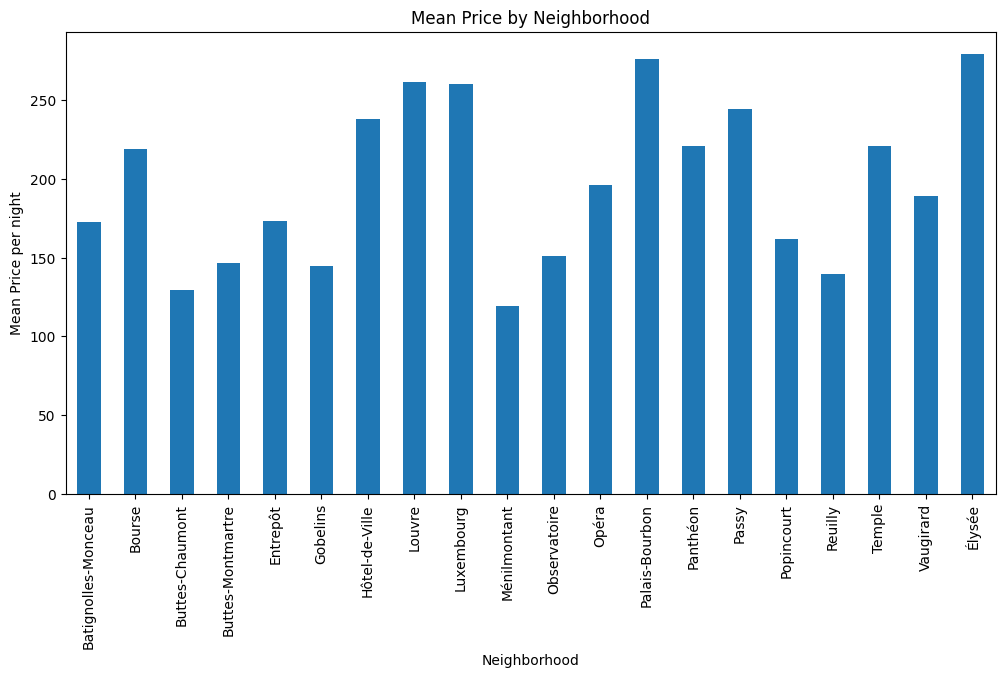

In [435]:
# Group dataset by neighborhood
grouped = data.groupby('neighbourhood_cleansed')
print(data.neighbourhood_cleansed.value_counts())

# Add a One hot Encoder for the neighborhoods

# Calculate the mean price for each neighborhood
mean_price = grouped['price'].mean()

# Plot the mean prices
plt.figure(figsize=(12, 6))
mean_price.plot(kind='bar')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Price per night')
plt.title('Mean Price by Neighborhood')
plt.show()


# One-hot encode the 'neighbourhood_cleansed' column
one_hot_encoded = pd.get_dummies(data['neighbourhood_cleansed'])

# Concatenate the one-hot encoded columns with the original dataframe
data = pd.concat([data, one_hot_encoded], axis=1)

data_neighborhood_name = data.neighbourhood_cleansed.unique().tolist()
neighborhood_string = ' + '.join([name.replace('-', '_') for name in data_neighborhood_name])

new_column_names = [col.replace('-', '_') for col in data.columns]
data.columns = new_column_names

# Drop the original 'neighbourhood_cleansed' column
data.drop('neighbourhood_cleansed', axis=1, inplace=True)

#print(data.columns)


In [436]:
print(neighborhood_string)

Observatoire + Hôtel_de_Ville + Entrepôt + Popincourt + Louvre + Bourse + Buttes_Montmartre + Gobelins + Luxembourg + Buttes_Chaumont + Reuilly + Élysée + Panthéon + Batignolles_Monceau + Vaugirard + Opéra + Palais_Bourbon + Passy + Temple + Ménilmontant


In [437]:
# Simple Regression on the Neighborhoods:
# We should remove a base category here Buttes-Montmartre
smf.ols(formula="ln_price ~ Observatoire + Hôtel_de_Ville + Entrepôt + Popincourt + Louvre + Bourse + Gobelins + Luxembourg + Buttes_Chaumont + Reuilly + Élysée + Panthéon + Batignolles_Monceau + Vaugirard + Opéra + Palais_Bourbon + Passy + Temple + Ménilmontant", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     140.4
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:37:47   Log-Likelihood:                -19009.
No. Observations:               21162   AIC:                         3.806e+04
Df Residuals:                   21142   BIC:                         3.822e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.8165      0.013    378.691      0.000       4.792       4.841
Observatoire[T.True]            0.0274      0.025      1.105      0.269      -0.021       0.076
Hôtel_de_Ville[T.True]          0.4307      0.024     18.105      0.000       0.384       0.477
Entrepôt[T.True]                0.1520      0.020      7.600      0.000       0.113       0.191
Popincourt[T.True]              0.0998      0.019      5.273      0.000       0.063       0.137
Louvre[T.True]                  0.5591      0.027     20.759      0.000       0.506       0.612
Bourse[T.True]                  0.3878      0.023     16.676      0.000       0.342       0.433
Gobelins[T.True]               -0.0337      0.027     -1.251      0.211      -0.086       0.019
Luxembourg[T.True]              0.4687      0.026     18.300      0.000       0.418       0.519
Buttes_Chaumont[T.True]        -0.1330      0.022     -6.028      0.000      -0.176      -0.090
Reuilly[T.True]                -0.0323      0.025     -1.285      0.199      -0.081       0.017
Élysée[T.True]                  0.5355      0.026     20.952      0.000       0.485       0.586
Panthéon[T.True]                0.3655      0.025     14.684      0.000       0.317       0.414
Batignolles_Monceau[T.True]     0.1215      0.021      5.847      0.000       0.081       0.162
Vaugirard[T.True]               0.2113      0.020     10.555      0.000       0.172       0.251
Opéra[T.True]                   0.2753      0.022     12.522      0.000       0.232       0.318
Palais_Bourbon[T.True]          0.5258      0.026     19.984      0.000       0.474       0.577
Passy[T.True]                   0.3949      0.022     18.278      0.000       0.353       0.437
Temple[T.True]                  0.3926      0.022     17.922      0.000       0.350       0.435
Ménilmontant[T.True]           -0.1640      0.023     -7.198      0.000      -0.209      -0.119
==============================================================================
Omnibus:                     1350.007   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2165.100
Skew:                           0.516   Prob(JB):                         0.00
Kurtosis:                       4.179   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Room Type

In [438]:
# Unerstanding of the different values of Room Type
print(f'{data.room_type.value_counts()}')


room_type
Entire home/apt    18527
Private room        2259
Hotel room           270
Shared room          106
Name: count, dtype: int64


In [439]:
# Modify the Room Type column to an Entire Home column
data.rename(columns={'room_type': 'Entire_room'}, inplace=True)
data.Entire_room = [1 if x == "Entire home/apt" else 0 for x in data.Entire_room]
print(data.Entire_room.value_counts())
 
smf.ols('ln_price ~ Entire_room', data=data).fit().summary()

Entire_room
1    18527
0     2635
Name: count, dtype: int64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     978.7
Date:                Sun, 03 Mar 2024   Prob (F-statistic):          4.55e-210
Time:                        19:37:47   Log-Likelihood:                -19788.
No. Observations:               21162   AIC:                         3.958e+04
Df Residuals:                   21160   BIC:                         3.960e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.6626      0.012    388.274      0.000       4.639       4.686
Entire_room     0.4015      0.013     31.285      0.000       0.376       0.427
==============================================================================
Omnibus:                     1601.111   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2254.048
Skew:                           0.637   Prob(JB):                         0.00
Kurtosis:                       3.966   Cond. No.                         5.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Beds

beds
13        1
90        1
85        1
77        1
79        1
12        1
17        1
83        1
18        2
11        2
10        3
9        12
8        30
7        55
6       161
5       375
4      1094
3      2468
2      6540
1     10412
Name: count, dtype: int64


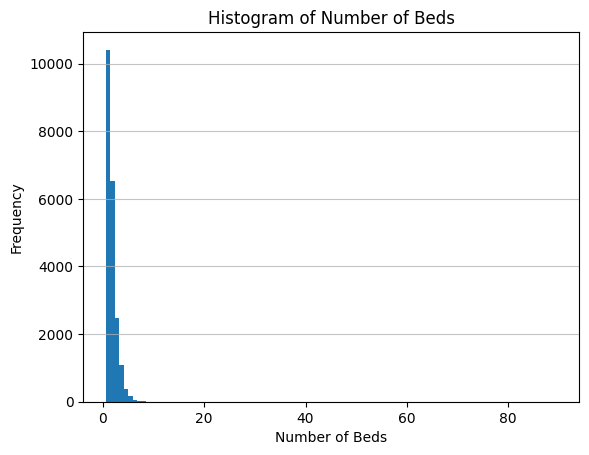

In [440]:
print(data['beds'].astype(int).value_counts().sort_values())

# Plot histogram
plt.hist(data['beds'], bins=100, align='left')
plt.xlabel('Number of Beds')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Beds')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [466]:
data.loc[data['beds']>10,'beds'] = 10 # winsorize extreme value becuase extremely rare and not common
data.beds.describe()

count    20974.000000
mean         1.844331
std          1.123065
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         10.000000
Name: beds, dtype: float64

In [467]:
smf.ols(formula="ln_price ~ beds", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     7351.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:39:05   Log-Likelihood:                -16905.
No. Observations:               20974   AIC:                         3.381e+04
Df Residuals:                   20972   BIC:                         3.383e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4899      0.007    624.205      0.000       4.476       4.504
beds           0.2856      0.003     85.736      0.000       0.279       0.292
==============================================================================
Omnibus:                     1484.583   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4056.548
Skew:                           0.396   Prob(JB):                         0.00
Kurtosis:                       5.004   Cond. No.                         4.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Bathrooms:

In [468]:
data.bathrooms_text.value_counts()

bathrooms_text
1 bath               14527
1.5 baths             1827
2 baths               1526
1 private bath        1207
1 shared bath          838
2.5 baths              424
3 baths                221
1.5 shared baths       136
3.5 baths               72
Half-bath               67
4 baths                 37
0 baths                 17
0 shared baths          13
4.5 baths               11
2 shared baths           9
Private half-bath        8
Shared half-bath         8
5 baths                  6
6 baths                  5
48 baths                 4
5.5 baths                3
49 baths                 2
2.5 shared baths         2
6 shared baths           1
7 baths                  1
47 baths                 1
6.5 baths                1
Name: count, dtype: int64

In [444]:
# transfer into numerical
tmp = data.bathrooms_text
tmp = tmp.replace({'Shared half-bath':0.5, 'Half-bath':0.5})
tmp = tmp.str.extractall(r'(\d+(?:\.\d+)?)')
tmp.columns =['n_bath']
tmp = tmp.reset_index(level=1).drop('match',axis=1)
data = data.merge(tmp,left_index=True,right_index=True,how = 'outer', validate='one_to_one')
data.n_bath = data.n_bath.astype('float')
data.n_bath.value_counts().sort_index()

n_bath
0.0        30
1.0     16729
1.5      1974
2.0      1549
2.5       429
3.0       221
3.5        73
4.0        37
4.5        11
5.0         6
5.5         3
6.0         6
6.5         1
7.0         1
47.0        1
48.0        4
49.0        2
Name: count, dtype: int64

In [445]:
data.loc[data['n_bath']>10,'n_bath'] = 10 # winsorize extreme value
data.n_bath.describe()

count    21077.000000
mean         1.192888
std          0.487146
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: n_bath, dtype: float64

In [469]:
smf.ols(formula="ln_price ~ n_bath", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     5332.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:43:07   Log-Likelihood:                -17565.
No. Observations:               20891   AIC:                         3.513e+04
Df Residuals:                   20889   BIC:                         3.515e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3260      0.010    421.895      0.000       4.306       4.346
n_bath         0.5807      0.008     73.018      0.000       0.565       0.596
==============================================================================
Omnibus:                     1789.658   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11640.241
Skew:                           0.077   Prob(JB):                         0.00
Kurtosis:                       6.654   Cond. No.                         5.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Review Scores Rating

In [470]:
data.review_scores_rating.describe()

count    20974.000000
mean         4.712337
std          0.389958
min          0.000000
25%          4.610000
50%          4.820000
75%          4.960000
max          5.000000
Name: review_scores_rating, dtype: float64

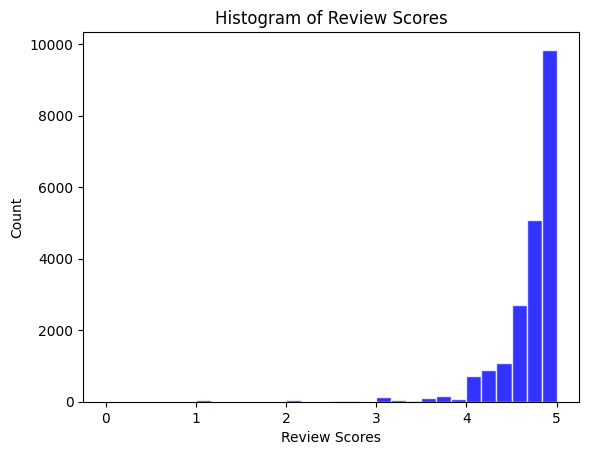

In [471]:
# plot histogram
plt.hist(data['review_scores_rating'], bins=30, color='blue', edgecolor='white', alpha=0.8)
plt.xlabel('Review Scores')
plt.ylabel('Count')
plt.title('Histogram of Review Scores')
plt.show()

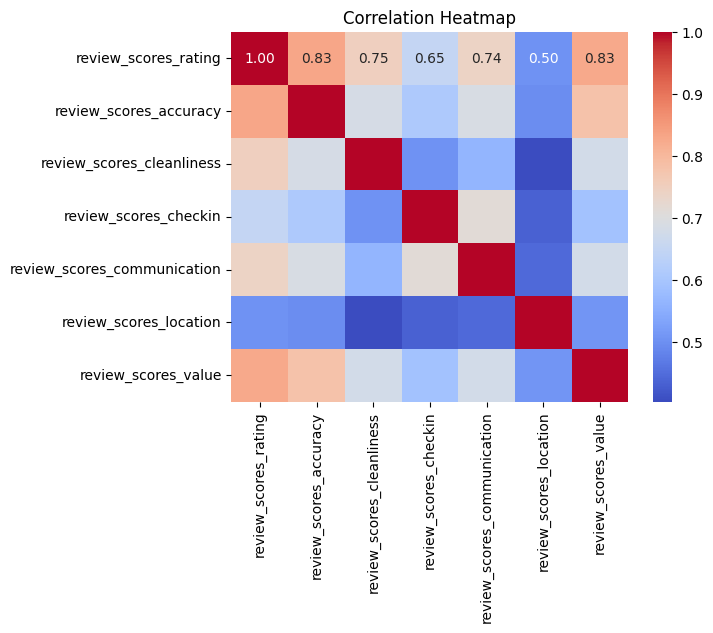

In [449]:
rscores = data.loc[:,[x for x in data.columns if 'review_scores' in x]]
correlation_matrix = rscores.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [472]:
smf.ols(formula="ln_price ~ review_scores_rating", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     282.9
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           4.46e-63
Time:                        19:51:26   Log-Likelihood:                -19915.
No. Observations:               20974   AIC:                         3.983e+04
Df Residuals:                   20972   BIC:                         3.985e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.1388      0.052     79.040      0.000       4.036       4.241
review_scores_rating     0.1863      0.011     16.821      0.000       0.165       0.208
==============================================================================
Omnibus:                     1458.465   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2087.966
Skew:                           0.591   Prob(JB):                         0.00
Kurtosis:                       3.995   Cond. No.                         59.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [473]:
smf.ols(formula="ln_price ~ review_scores_location", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     495.1
Date:                Sun, 03 Mar 2024   Prob (F-statistic):          1.95e-108
Time:                        19:51:29   Log-Likelihood:                -19811.
No. Observations:               20974   AIC:                         3.963e+04
Df Residuals:                   20972   BIC:                         3.964e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.4467      0.071     48.763      0.000       3.308       3.585
review_scores_location     0.3260      0.015     22.252      0.000       0.297       0.355
==============================================================================
Omnibus:                     1482.401   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2152.811
Skew:                           0.593   Prob(JB):                         0.00
Kurtosis:                       4.028   Cond. No.                         82.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [452]:
data.minimum_nights.describe()

count    21162.000000
mean         8.653483
std         33.673635
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max       1000.000000
Name: minimum_nights, dtype: float64

In [453]:
minimum_nightsH = data.minimum_nights.mean()+3*data.minimum_nights.std()
minimum_nightsL = data.minimum_nights.mean()-3*data.minimum_nights.std()
data = data.loc[(data.minimum_nights < minimum_nightsH) & (data.minimum_nights > minimum_nightsL) ]
data.minimum_nights.describe()

count    20974.000000
mean         5.807857
std         11.541321
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max        100.000000
Name: minimum_nights, dtype: float64

In [454]:
smf.ols(formula="ln_price ~ minimum_nights", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     572.2
Date:                Sun, 03 Mar 2024   Prob (F-statistic):          8.95e-125
Time:                        19:37:49   Log-Likelihood:                -19774.
No. Observations:               20974   AIC:                         3.955e+04
Df Residuals:                   20972   BIC:                         3.957e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.0682      0.005   1055.497      0.000       5.059       5.078
minimum_nights    -0.0089      0.000    -23.920      0.000      -0.010      -0.008
==============================================================================
Omnibus:                     1595.014   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2262.394
Skew:                           0.636   Prob(JB):                         0.00
Kurtosis:                       3.985   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [455]:
data.host_is_superhost.value_counts()

host_is_superhost
f    14527
t     6447
Name: count, dtype: int64

In [456]:
smf.ols(formula="ln_price ~ host_is_superhost", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     101.3
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           8.99e-24
Time:                        19:37:49   Log-Likelihood:                -20005.
No. Observations:               20974   AIC:                         4.001e+04
Df Residuals:                   20972   BIC:                         4.003e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4.9875      0.005    957.089      0.000       4.977       4.998
host_is_superhost[T.t]     0.0946      0.009     10.064      0.000       0.076       0.113
==============================================================================
Omnibus:                     1470.070   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2110.276
Skew:                           0.594   Prob(JB):                         0.00
Kurtosis:                       4.002   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [457]:
data.accommodates.describe()

count    20974.000000
mean         3.261371
std          1.705785
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: accommodates, dtype: float64

In [458]:
smf.ols(formula="ln_price ~ accommodates", data=data).fit().summary() # same thing as beds no need redundancies

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                 1.067e+04
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:37:49   Log-Likelihood:                -15744.
No. Observations:               20974   AIC:                         3.149e+04
Df Residuals:                   20972   BIC:                         3.151e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.3177      0.008    565.351      0.000       4.303       4.333
accommodates     0.2143      0.002    103.279      0.000       0.210       0.218
==============================================================================
Omnibus:                     1788.914   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4618.697
Skew:                           0.498   Prob(JB):                         0.00
Kurtosis:                       5.072   Cond. No.                         8.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [459]:
data['ln_accommodates'] = np.log(data['accommodates'])
smf.ols(formula="ln_price ~ ln_accommodates+accommodates", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     5662.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:37:49   Log-Likelihood:                -15528.
No. Observations:               20974   AIC:                         3.106e+04
Df Residuals:                   20971   BIC:                         3.109e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.2268      0.009    484.641      0.000       4.210       4.244
ln_accommodates     0.4980      0.024     20.886      0.000       0.451       0.545
accommodates        0.0799      0.007     11.830      0.000       0.067       0.093
==============================================================================
Omnibus:                     1810.637   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3991.829
Skew:                           0.551   Prob(JB):                         0.00
Kurtosis:                       4.831   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [460]:
data.number_of_reviews.describe()

count    20974.000000
mean        44.745161
std         78.590477
min          1.000000
25%          6.000000
50%         18.000000
75%         50.000000
max       2636.000000
Name: number_of_reviews, dtype: float64

In [461]:
smf.ols(formula="ln_price ~ number_of_reviews", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     58.18
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           2.49e-14
Time:                        19:37:50   Log-Likelihood:                -20027.
No. Observations:               20974   AIC:                         4.006e+04
Df Residuals:                   20972   BIC:                         4.007e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.0354      0.005   1007.958      0.000       5.026       5.045
number_of_reviews    -0.0004   5.52e-05     -7.628      0.000      -0.001      -0.000
==============================================================================
Omnibus:                     1416.621   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1985.491
Skew:                           0.587   Prob(JB):                         0.00
Kurtosis:                       3.946   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [462]:
data['ln_number_of_reviews'] = np.log(data['number_of_reviews']+1e-10 )  # +1e-10 to avoid -inf
data.ln_number_of_reviews.describe()

count    2.097400e+04
mean     2.821854e+00
std      1.487133e+00
min      1.000000e-10
25%      1.791759e+00
50%      2.890372e+00
75%      3.912023e+00
max      7.877018e+00
Name: ln_number_of_reviews, dtype: float64

In [463]:
smf.ols(formula="ln_price ~ ln_number_of_reviews+number_of_reviews", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     32.58
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           7.48e-15
Time:                        19:37:50   Log-Likelihood:                -20023.
No. Observations:               20974   AIC:                         4.005e+04
Df Residuals:                   20971   BIC:                         4.008e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.0116      0.010    486.024      0.000       4.991       5.032
ln_number_of_reviews     0.0106      0.004      2.638      0.008       0.003       0.019
number_of_reviews       -0.0006   7.63e-05     -7.343      0.000      -0.001      -0.000
==============================================================================
Omnibus:                     1434.746   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2018.458
Skew:                           0.591   Prob(JB):                         0.00
Kurtosis:                       3.956   Cond. No.                         228.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## model selection

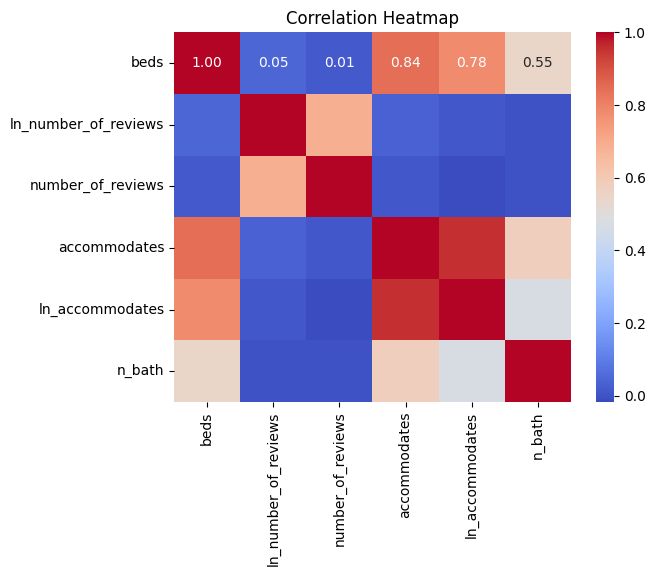

In [464]:
factors = data.loc[:,['beds','ln_number_of_reviews','number_of_reviews','accommodates','ln_accommodates','n_bath']]
correlation_matrix = factors.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [465]:
smf.ols(formula="ln_price ~ room_type+beds+room_type+ln_number_of_reviews+number_of_reviews+accommodates+ln_accommodates+n_bath+host_is_superhost ", data=data).fit().summary()

PatsyError: Error evaluating factor: NameError: name 'room_type' is not defined
    ln_price ~ room_type+beds+room_type+ln_number_of_reviews+number_of_reviews+accommodates+ln_accommodates+n_bath+host_is_superhost
               ^^^^^^^^^

In [ ]:
smf.ols(formula="ln_price ~ room_type+beds+room_type+number_of_reviews+accommodates+ln_accommodates+n_bath+host_is_superhost + Observatoire + Hôtel_de_Ville + Entrepôt + Popincourt + Louvre + Bourse + Gobelins + Luxembourg + Buttes_Chaumont + Reuilly + Élysée + Panthéon + Batignolles_Monceau + Vaugirard + Opéra + Palais_Bourbon + Passy + Temple + Ménilmontant", data=data).fit().summary()

In [ ]:
# Attention think of cross_validation